In [1]:
pip install torch torchvision matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
from torch import optim
import os
os.environ['WANDB_CONSOLE'] = 'off'

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)
print(train_data)
print(test_data)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


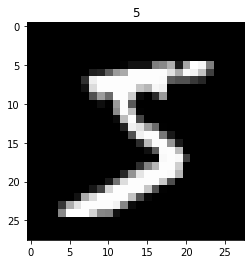

In [4]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

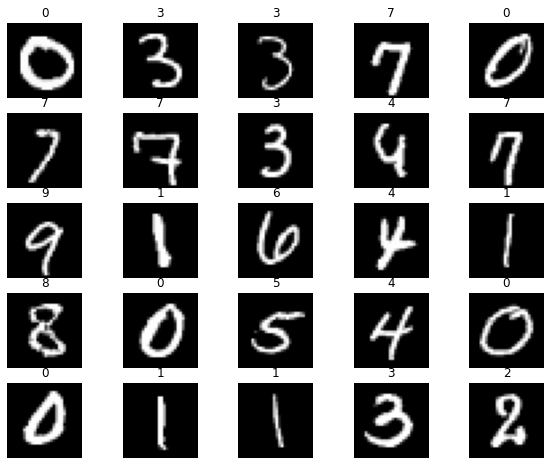

In [5]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [14]:
## Helper file
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable

def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # Initialise for the inputs and targets
    inputs = images
    targets = images

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its 
        reconstruction also a PyTorch Tensor 
    '''
    
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,7), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10).astype(int), size='large');
    ax2.set_title('Digit Probability')
    ax2.set_xlim(0, 1.1)

In [17]:
import torch.nn.functional as torchFn

class Network(nn.Module):
    def __init__(self, drop_prob=0.0005):
        super().__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(8, 8, 3, stride=1, padding=1)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(16, 32, 3, stride=1, padding=1)
        self.upconv4 = nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1)
        self.out = nn.ConvTranspose2d(64, 1, 3, stride=1, padding=1)
        
        self.drop = nn.Dropout2d(p=drop_prob)
    
    def forward(self, x):
        x = self.encode(x)
        logits = self.decode(x)
        
        return logits

    def encode(self, x):
        x = self.drop(torchFn.relu(self.conv1(x)))
        x = self.drop(torchFn.relu(self.conv2(x)))
        x = self.drop(torchFn.relu(self.conv3(x)))
        x = torchFn.relu(self.conv4(x))
        x = torchFn.relu(self.conv5(x))
        return x
        
    def decode(self, x):
        x = self.drop(torchFn.relu(self.upconv1(x, output_size=(7,7))))
        x = self.drop(torchFn.relu(self.upconv2(x, output_size=(14,14))))
        x = self.drop(torchFn.relu(self.upconv3(x, output_size=(14,14))))
        x = self.drop(torchFn.relu(self.upconv4(x, output_size=(28,28))))
        x = self.out(x)
        return x

In [8]:
import torchvision

In [9]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=4
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
## Check if network runs error-free
net = Network()
test_network(net, train_loader)

True

Epoch: 1/1.. Loss: 0.0321.. Test loss: 0.0222.. 0.0173 s/batch


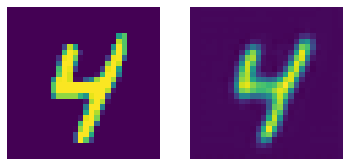

Epoch: 1/1.. Loss: 0.0318.. Test loss: 0.0224.. 0.0140 s/batch


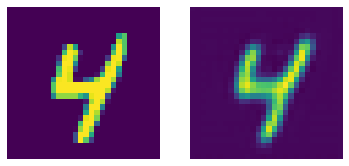

Epoch: 1/1.. Loss: 0.0317.. Test loss: 0.0231.. 0.0165 s/batch


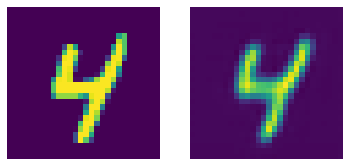

Epoch: 1/1.. Loss: 0.0319.. Test loss: 0.0244.. 0.0220 s/batch


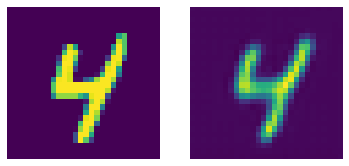

In [18]:
## Training

import time
from torch.autograd import Variable

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epochs = 1
print_every = 200  # Number of training steps to print losses
show_every = 1000  # Number of training steps to show reconstructions
cuda = True        # Train on GPU or not

if cuda:
    net.cuda()

steps = 0
running_loss = 0
for e in range(epochs):
    start = time.time()
    for images, labels in iter(train_loader):
        steps += 1

        inputs = images
        targets = images
        
        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        optimizer.zero_grad()
        
        output = net.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data
        
        if steps % print_every == 0:
            net.eval()
            stop = time.time()
            # Test accuracy
            val_loss = 0
            for ii, (images, labels) in enumerate(test_loader):
                inputs = images
                targets = images
                if cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()
                
                output = net.forward(inputs)
                val_loss += criterion(output, targets).data
                
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test loss: {:.4f}..".format(val_loss/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            
            running_loss = 0
            start = time.time()
            net.train()
              
            net.cpu()
            net.eval()
            img = images[3]
            x = img.resize_(1, *img.size())
            recon = net(x)
            
            view_recon(img, recon)
            plt.show()
            if cuda:
                net.cuda()
            net.train()

